# Updated Logistic Regression
***

In this module I will:

- Review findings of the last update.
- Interpret the meaning of the clustered champion categoricals and provide more meaningful labels for each cluster.
- Create a new logistic regression model based on the newly interpretted clusters.
- Evaluate the quality of this new model.
- Create a list of team compositions from all combinations of the new champion categoricals.
- Group teamDF by these team compositions to see which perform most effectively in terms of win pct and gspd.
- Investigate which teams most frequently draft the most and least successful compositions.

If possible I will also:

- Run another round of t-SNE and kmeans clustering on the champion categorical updated team data to see if any natural groups of team types exist and how well each of them perform.
- Evaluate how many games can be considered 'close', to be used in an analysis where more of the original features can be retained.

**DISCLOSURE**: I realized while interpretting the meaning of clustered champion categoricals that I forgot to include 'waterdrakes' in my list of leak features in last week's update. This unfortunately led to a feature I had not intended to include being a major determinant of cluster assignment for junglers. So I reran the t-SNE implementations from last week with the correct features and have loaded the results of that into this notebook.

In [111]:
%store -r teamDF
%store -r playerDF

# k_players is a cleaned up copy of playerDF (fully NaN columns dropped, NaN row values imputed by mean or
# median depending on outlier concentration of feature).   
%store -r k_players

# position_dfs is a list of player position dataframes with features limited to the regressors, indexed by gameid and player
%store -r position_dfs

# tsne_data is a dictionary of t-SNE results for each player position and a set of different tuning parameters for sklearn's
# TSNE
%store -r tsne_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr

# Review Of Last Update

Last week I ran I series of t-SNE dimensionality reductions on a 'leak-free' view of each partition of the `k_players` dataframe, changing the tuning parameters of the t-SNE algorithm as I went and judging the results by which implementations resulted in the lowest KL Divergence values provided mean sigma stayed reasonable below 1. I discovered that the best results for all implementations came when the max iterations was set to 5k, the perplexity to 100, and the learning rate (for all but top lane) set to 1000.

I then examined the results in a scatterplot grid to identify the natural number of clusters in each partition, ran a round of kmeans clustering based on those observed numbers of clusters, and created another scatterplot grid showing the cluster assignments by color.

## Review of last update (cont'd)

Surprisingly, the observations were not clustered in a way I expected them to be from the t-SNE plots. Where I saw what I thought was a natural cluster of observations that I expected to share a color, kmeans disagreed.

After our meeting, I decided to play around with the clustering and visualizations to see what was going on (by tweaking values in the list `k_count` in the following code). I noticed that even though the clusters weren't being split into the bins I expected from the original plots, they were being consistently split (meaning, colors weren't arbitrarily being assigned all over the plots).

This is probably not a valid technique, but I decided to rerun my clustering and visualization code a few times, on each iteration raising the values of `k_count` until the point that colors started to appear assigned arbitrarily around the plots, and when I got to such a point, taking down that particular value by 1. The following is the result of that tinkering.

In [188]:
k_count = [3,3,3,3,3]

for i, df in enumerate(position_dfs):
    kmeans = KMeans(n_clusters = k_count[i])
    kmeans.fit(df)
    df['cluster'] = kmeans.labels_

for df in position_dfs:
    try:
        df['cluster'] = df['cluster'].astype('category')
    except:
        print('Column {} cannot be converted to categorical.'.format(col))

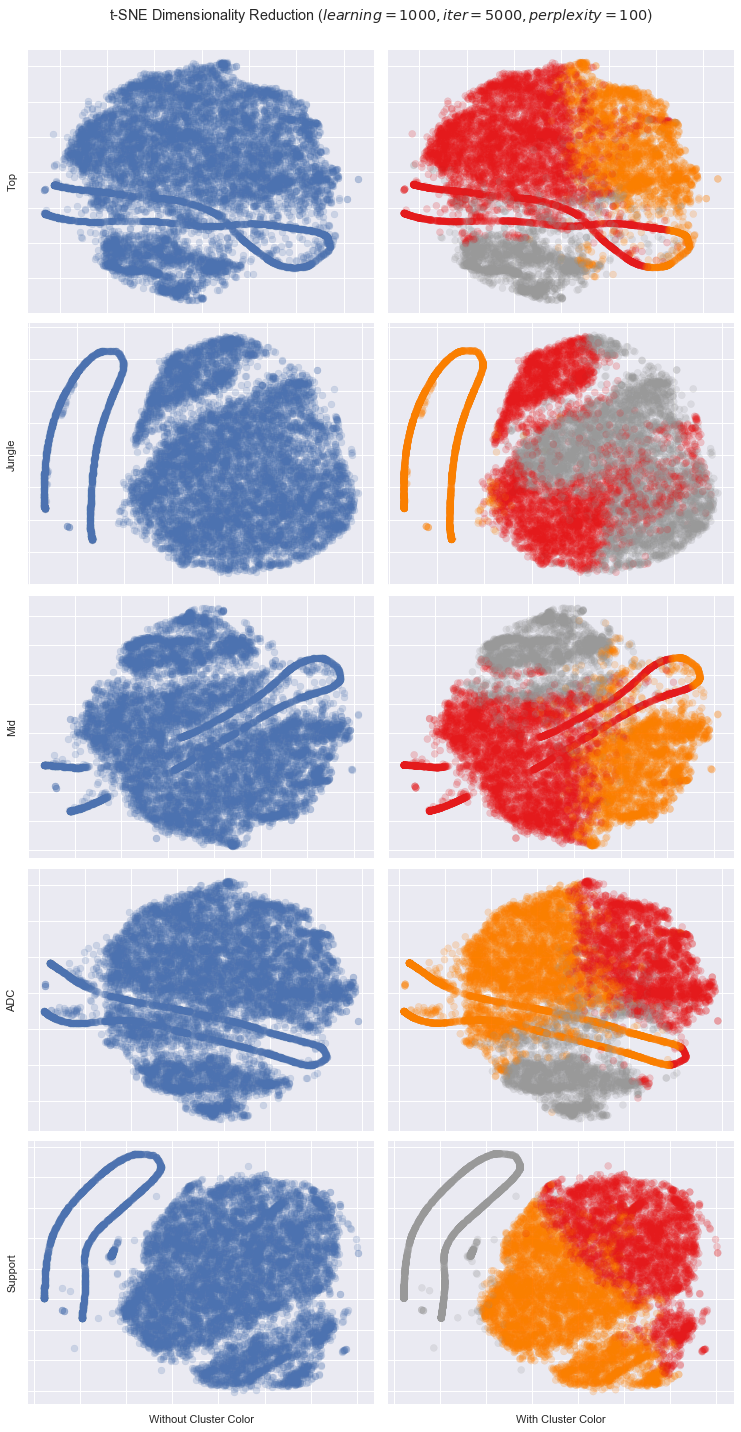

In [191]:
f, ((ax1, ax6), (ax2, ax7), (ax3, ax8), (ax4, ax9), (ax5, ax10)) = plt.subplots(5, 2, figsize=(10,20))
f.suptitle('t-SNE Dimensionality Reduction ($learning = 1000, iter = 5000, perplexity = 100$)')

for i, l in enumerate(['Top', 'Jungle', 'Mid', 'ADC', 'Support']):
    data = tsne_data[l]['L1000p100']
    eval('ax'+str(i+1)).scatter(data[:, 0], data[:, 1], alpha = .2)
    eval('ax'+str(i+1)).set_yticklabels([])
    eval('ax'+str(i+1)).set_xticklabels([])
    
    eval('ax'+str(i+6)).scatter(data[:, 0], data[:, 1], c = position_dfs[i].cluster,
                                cmap = plt.cm.get_cmap('Set1', k_count[i]), alpha = .2)
    eval('ax'+str(i+6)).set_yticklabels([])
    eval('ax'+str(i+6)).set_xticklabels([])

ax1.set_ylabel('Top')
ax2.set_ylabel('Jungle')
ax3.set_ylabel('Mid')
ax4.set_ylabel('ADC')
ax5.set_ylabel('Support')
ax5.set_xlabel('Without Cluster Color')
ax10.set_xlabel('With Cluster Color')
plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.95, wspace=.04, hspace=.04)
plt.show()

### Conclusions of review

The end determination of this process is that there should be 3 clusters for each position categorization.

**NOTE:** The method used to arrive at these cluster numbers struggled when deciding on jungle and support, but the assignments at the chosen numbers seemed the most sensible from the following visualizations. Oddly, before correcting the error I detected from last week, I was having the opposite problem, where jungle clusters had very clear splits up to 9 clusters.

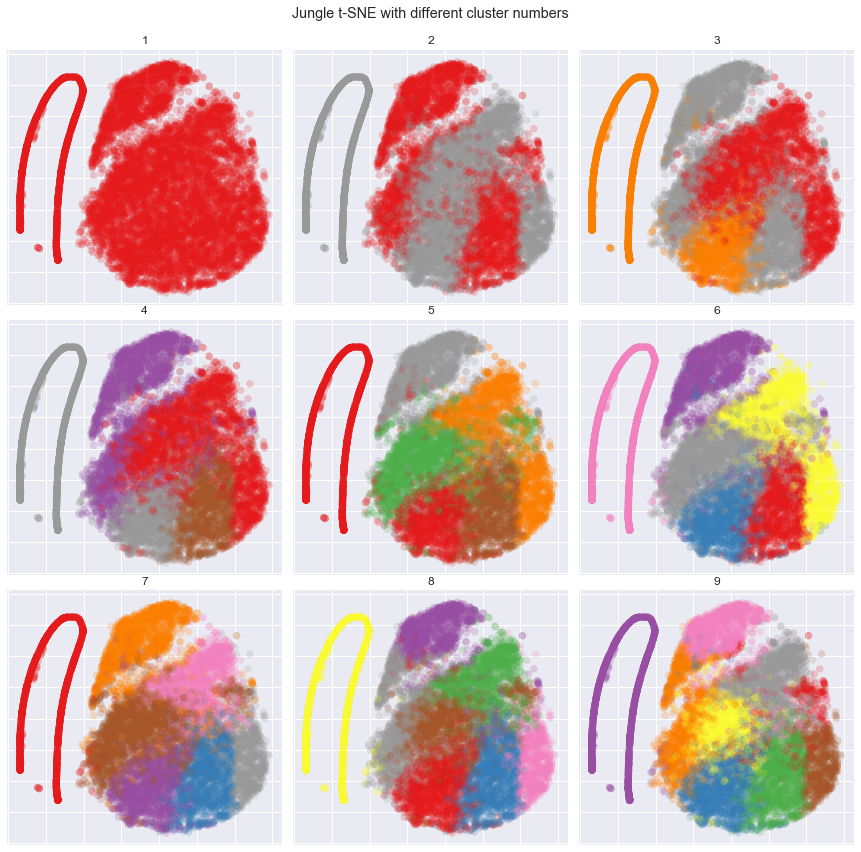

In [133]:
jung_display = [0 for i in range(10)]

for i in range(1,10):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(position_dfs[1])
    jung_display[i] = kmeans.labels_

f, ((ax1, ax2, ax3), (ax4, ax5,ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12,12))
f.suptitle('Jungle t-SNE with different cluster numbers')
data = tsne_data['Jungle']['L1000p100']

for i in range(1,10):
    eval('ax'+str(i)).scatter(data[:, 0], data[:, 1], c = jung_display[i],
                                cmap = plt.cm.get_cmap('Set1', i), alpha = .2)
    eval('ax'+str(i)).set_yticklabels([])
    eval('ax'+str(i)).set_xticklabels([])
    eval('ax'+str(i)).set_title(str(i))

plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.93, wspace=.04, hspace=.06)
plt.show()

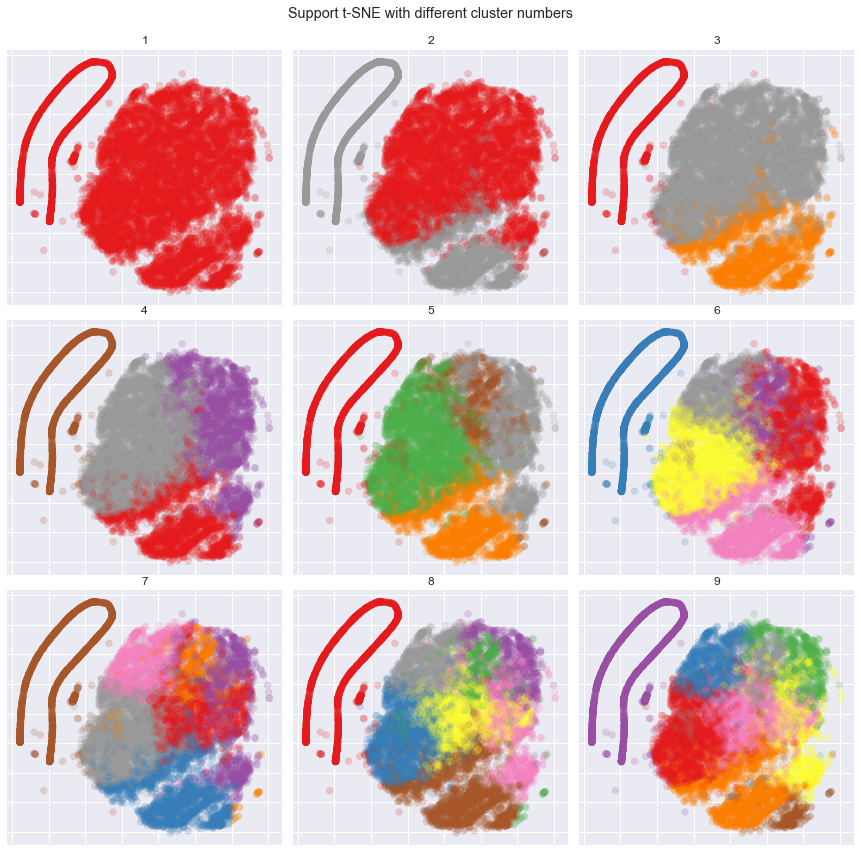

In [134]:
sup_display = [0 for i in range(10)]

for i in range(1,10):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(position_dfs[4])
    sup_display[i] = kmeans.labels_

f, ((ax1, ax2, ax3), (ax4, ax5,ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12,12))
f.suptitle('Support t-SNE with different cluster numbers')
data = tsne_data['Support']['L1000p100']

for i in range(1,10):
    eval('ax'+str(i)).scatter(data[:, 0], data[:, 1], c = sup_display[i],
                                cmap = plt.cm.get_cmap('Set1', i), alpha = .2)
    eval('ax'+str(i)).set_yticklabels([])
    eval('ax'+str(i)).set_xticklabels([])
    eval('ax'+str(i)).set_title(str(i))

plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.93, wspace=.04, hspace=.06)
plt.show()

## Interpretting the clusters

I'll bring back my helper function to take a look at which features are the driving forces behind the cluster assignments.

In [85]:
def get_cluster_factors(df, spread = 1):
    dummies = [f for f in list(df) if 'champion_' in f]
    sd = df.std()
    g = df.drop(dummies, axis = 'columns').groupby('cluster').mean()
    big_factors = [(c, (max(g[c]) - min(g[c]))/sd[c]) for c in g if max(g[c]) - min(g[c]) >= spread*sd[c]]
    big_factors = [(b[0], float("{0:.3f}".format(b[1]))) for b in big_factors]
    return sorted(big_factors, reverse = True, key=lambda x: x[1])

### Interpretting clusters (cont'd)

I'll feed each of the positional dataframes into my helper function to see which features differed by more than one standard deviation across clusters.

In [192]:
for label,df in zip(['Top', 'Jungle', 'Mid', 'ADC', 'Support'], position_dfs):
    print(label,'--')
    print(get_cluster_factors(df), '\n')

Top --
[('fttime', 2.127), ('gamelength', 1.454), ('fdtime', 1.39), ('fbarontime', 1.332)] 

Jungle --
[('monsterkillsownjungle', 2.396), ('monsterkillsenemyjungle', 1.468), ('wcpm', 1.205), ('wpm', 1.119)] 

Mid --
[('fttime', 2.032), ('gamelength', 1.392), ('fdtime', 1.335), ('fbarontime', 1.293)] 

ADC --
[('fttime', 2.076), ('fdtime', 1.356), ('gamelength', 1.327), ('fbarontime', 1.222)] 

Support --
[('monsterkillsownjungle', 2.516), ('wpm', 2.427), ('wardshare', 2.4), ('earnedgoldshare', 2.302), ('dmgshare', 1.949), ('monsterkillsenemyjungle', 1.775), ('fbarontime', 1.394), ('wcpm', 1.36), ('gamelength', 1.285)] 



In [193]:
for label,df in zip(['Top', 'Jungle', 'Mid', 'ADC', 'Support'], position_dfs):
    print(label,'--')
    print(get_cluster_factors(df, .5), '\n')

Top --
[('fttime', 2.127), ('gamelength', 1.454), ('fdtime', 1.39), ('fbarontime', 1.332), ('wardshare', 0.607), ('monsterkillsownjungle', 0.595), ('dmgshare', 0.571)] 

Jungle --
[('monsterkillsownjungle', 2.396), ('monsterkillsenemyjungle', 1.468), ('wcpm', 1.205), ('wpm', 1.119), ('dmgshare', 0.925), ('fttime', 0.902), ('gamelength', 0.815), ('fdtime', 0.771), ('fbarontime', 0.756), ('wardshare', 0.572), ('earnedgoldshare', 0.549)] 

Mid --
[('fttime', 2.032), ('gamelength', 1.392), ('fdtime', 1.335), ('fbarontime', 1.293), ('dmgshare', 0.946), ('monsterkillsownjungle', 0.806), ('fbtime', 0.646), ('wardshare', 0.635), ('earnedgoldshare', 0.536)] 

ADC --
[('fttime', 2.076), ('fdtime', 1.356), ('gamelength', 1.327), ('fbarontime', 1.222), ('monsterkillsownjungle', 0.909), ('earnedgoldshare', 0.825), ('dmgshare', 0.812), ('wardshare', 0.746), ('wcpm', 0.73), ('fbtime', 0.605)] 

Support --
[('monsterkillsownjungle', 2.516), ('wpm', 2.427), ('wardshare', 2.4), ('earnedgoldshare', 2.302

In [148]:
full_pos_DFs = {}
full_pos_DFs['Top'] = k_players.loc[k_players.position == 'Top', :].copy()
full_pos_DFs['Top']['cluster'] = position_dfs[0].cluster
get_cluster_factors(full_pos_DFs['Top'])

[('fttime', 2.127),
 ('xpat10', 1.665),
 ('oppxpat10', 1.635),
 ('gamelength', 1.454),
 ('fdtime', 1.39),
 ('fbarontime', 1.332),
 ('minionkills', 1.263),
 ('goldspent', 1.225),
 ('totalgold', 1.219),
 ('wards', 1.098)]

In [149]:
full_pos_DFs['Top'].groupby('cluster').mean()['result']

cluster
0    0.495855
1    0.504743
2    0.498983
Name: result, dtype: float64

In [189]:
for i,pos in enumerate(['Jungle', 'Middle', 'ADC', 'Support']):
    full_pos_DFs[pos] = k_players.loc[k_players.position == pos, :].copy()
    full_pos_DFs[pos]['cluster'] = position_dfs[i+1].cluster

In [196]:
# from previous vif testing - but with ['oppxpat10', 'oppgoldat10', 'oppgoldat15']
# still included among columns
player_vif_inflators = ['result','elementals',
                        'side_Blue', 'monsterkills', 'wards', 'dmgtochamps', 'minionkills',
                       'ckpm', 'k', 'wardkills', 'totalgold', 'earnedgpm', 'teamdragkills',
                        'visionwardbuys', 'visionwards', 'teamdeaths']

for k in full_pos_DFs.keys():
    cols = list(set(list(full_pos_DFs[k])) - set(player_vif_inflators))
    print(k, ':\n', get_cluster_factors(full_pos_DFs[k].loc[:, cols], .6), '\n')

Top :
 [('fttime', 2.127), ('xpat10', 1.665), ('oppxpat10', 1.635), ('gamelength', 1.454), ('fdtime', 1.39), ('fbarontime', 1.332), ('goldspent', 1.225), ('dmgtochampsperminute', 0.701), ('cspm', 0.665), ('wardshare', 0.607)] 

Jungle :
 [('pentas', 2.614), ('monsterkillsownjungle', 2.396), ('cspm', 1.757), ('monsterkillsenemyjungle', 1.468), ('wcpm', 1.205), ('wpm', 1.119), ('dmgshare', 0.925), ('fttime', 0.902), ('fd', 0.874), ('goldspent', 0.833), ('gamelength', 0.815), ('fdtime', 0.771), ('fbarontime', 0.756), ('oppelementals', 0.728)] 

Middle :
 [('fttime', 2.032), ('gamelength', 1.392), ('fdtime', 1.335), ('fbarontime', 1.293), ('goldspent', 1.259), ('dmgshare', 0.946), ('monsterkillsownjungle', 0.806), ('goldat10', 0.769), ('oppgoldat10', 0.693), ('dmgtochampsperminute', 0.646), ('fbtime', 0.646), ('wardshare', 0.635)] 

ADC :
 [('fttime', 2.076), ('fdtime', 1.356), ('goldspent', 1.333), ('gamelength', 1.327), ('fbarontime', 1.222), ('monsterkillsownjungle', 0.909), ('dmgtocham

In [190]:
for k in full_pos_DFs.keys():
    print(k, ':\n',
          full_pos_DFs[k].groupby("cluster")['result'].agg([np.mean, 'count']).rename(columns={"mean": "win_pct"}), '\n')

Top :
           win_pct  count
cluster                 
0        0.495855   1930
1        0.504743   2952
2        0.498983   5900 

Jungle :
           win_pct  count
cluster                 
0        0.497929   4346
1        0.489852   1823
2        0.505961   4613 

Middle :
           win_pct  count
cluster                 
0        0.498505   5685
1        0.506389   2974
2        0.495054   2123 

ADC :
           win_pct  count
cluster                 
0        0.509213   2985
1        0.493871   5629
2        0.503229   2168 

Support :
           win_pct  count
cluster                 
0        0.512215   3725
1        0.491816   5254
2        0.498613   1803 



**NOTE:** While playing with the number of jungle clusters, 4 and 5 each put about 2k observations in the winner group, and 3k in the loser. 6 clusters resulted in 2k in the winner group but split the loser group into big losers (.42, 1.7k) and slight losers (.48, 1.8k). 7 clusters reduced the winners (.58) to 1.7k and losers (.42) to 1.6k.

In [217]:
def get_per_cluster_factors(df, spread = 1):
    sd = df.std()
    non_num = ['patchno','side','position','team','champion', 'cluster']
    cols = list(df.drop(non_num, axis = 'columns'))
    groups = df.groupby('cluster')
    for i,d1 in groups:
        big_factors = []
        g1 = d1.mean()
        for j,d2 in groups:
            if i!=j:
                g2 = d2.mean()
                for c in cols:
                    if g1[c] - g2[c] >= spread*sd[c]:
                        big_factors.append((c, float("{0:.3f}".format((g1[c] - g2[c])/sd[c])), 'Above group {}'.format(j)))
        print('Group', i)
        print(sorted(big_factors, reverse = True, key=lambda x: x[1]), '\n')

In [356]:
for k in full_pos_DFs.keys():
    cols = list(set(list(full_pos_DFs[k])) - set(player_vif_inflators))
    print(k)
    get_per_cluster_factors(full_pos_DFs[k].loc[:, cols], .6)

Top
Group 0
[('fbarontime', 0.653, 'Above group 2')] 

Group 1
[('fttime', 2.127, 'Above group 0'), ('xpat10', 1.665, 'Above group 0'), ('oppxpat10', 1.635, 'Above group 0'), ('gamelength', 1.454, 'Above group 2'), ('fdtime', 1.39, 'Above group 0'), ('fbarontime', 1.332, 'Above group 2'), ('goldspent', 1.225, 'Above group 2'), ('gamelength', 0.879, 'Above group 0'), ('goldspent', 0.808, 'Above group 0'), ('dmgtochampsperminute', 0.701, 'Above group 0'), ('fbarontime', 0.679, 'Above group 0'), ('cspm', 0.665, 'Above group 0')] 

Group 2
[('fttime', 1.761, 'Above group 0'), ('xpat10', 1.454, 'Above group 0'), ('oppxpat10', 1.435, 'Above group 0'), ('fdtime', 0.874, 'Above group 0'), ('wardshare', 0.607, 'Above group 0')] 

Jungle
Group 0
[('monsterkillsownjungle', 1.926, 'Above group 1'), ('monsterkillsenemyjungle', 1.167, 'Above group 1'), ('wpm', 1.119, 'Above group 1'), ('fd', 0.851, 'Above group 1'), ('wcpm', 0.763, 'Above group 1'), ('oppelementals', 0.628, 'Above group 1')] 

Group

In [350]:
def show_cluster_factors(df, spread=1):
    player_vif_inflators = ['result','elementals',
                            'side_Blue', 'monsterkills', 'wards', 'dmgtochamps', 'minionkills',
                           'ckpm', 'k', 'wardkills', 'totalgold', 'earnedgpm', 'teamdragkills',
                            'visionwardbuys', 'visionwards', 'teamdeaths']
    factor_cols = list(set(list(df)) - set(player_vif_inflators))
    cols = get_cluster_factors(df[factor_cols], spread)
    cols = [c[0] for c in cols]
    g = df[cols]
    sd = g.std()
    
    ax = (g.groupby(df.cluster)[cols].mean()/sd).transpose().plot(kind = 'bar', rot = 45, figsize=(20, 10))
    ax.tick_params(axis = 'x', labelsize = 14)
    ax.set_title(df.position.iloc[0])
    ax.title.set_fontsize(20)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
#     ax.xaxis.set_ticklabels([])
#     table = ax.tables[0]
#     table.set_fontsize(100)
#     table.scale(1,4)
    plt.show()

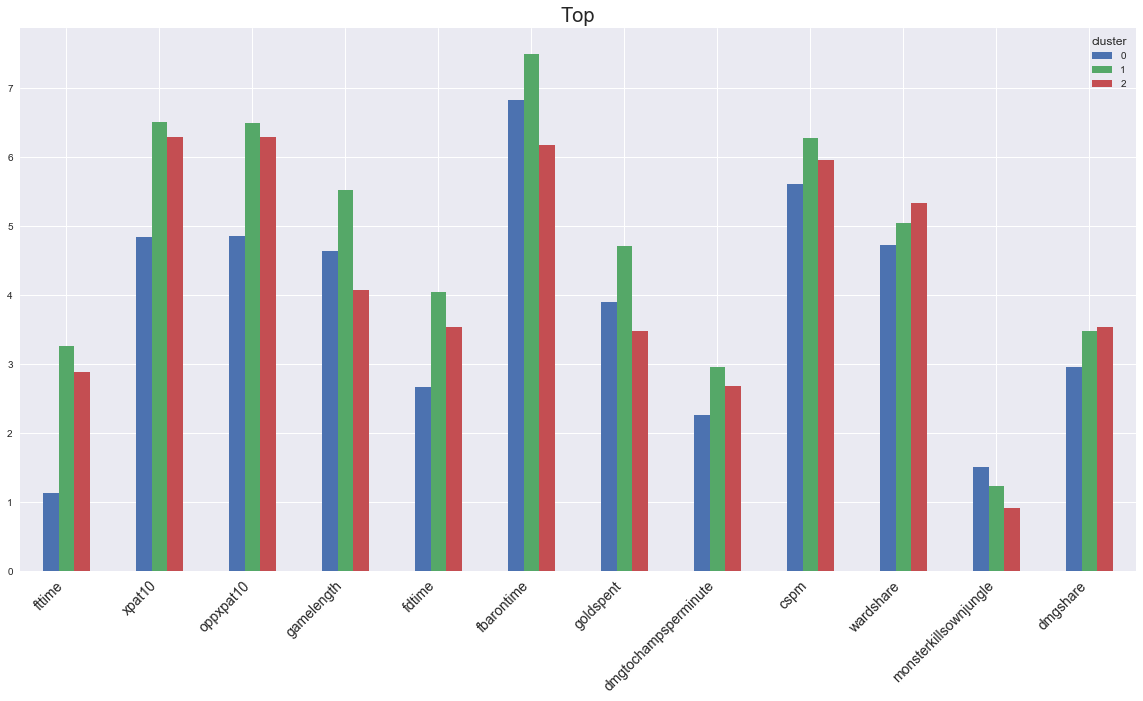

In [351]:
show_cluster_factors(full_pos_DFs['Top'], .5)

My instinct is to say cluster 0 is showing top laners in lane swap games, due to the very early first turret time, and high number of of own jung monsters killed. Top laners in lane swaps also fall behind in xp as reflected by both the player's and opponent's xp at 10 being extremely low. My hesitation is that lane swaps from my understanding, accellerated the pace of the game, but this does not appear to be the case here. But the top laner being disadvantaged by the lane swap meta is reflected in their dmgshare, dmg per minute, and cspm. Lane swaps tended to favor tanks in the top lane because they were better equipped to hold their turret longer and were more able to contribute in team fights if behind in farm, so that could also be influencing dmgshare.

I think that cluster 1 is depicting split-pushers due to the longest game length, high dmgshare, medium wardshare, highest xp for them and opponent (because opponent must spend more time in lane contesting their push), (because they are often on an island), slowest baron and first dragon time (because regardless who claims them, the split-push team's goal is to contest and stall neutral objectives while their split-pusher pressures another side of the map).

Cluster 2 I think may be a mix of assassins, tanks, and bruisers - basically, skirmish focused. Their high ward share represents constant roaming, relatively high xp due to kills and assists in team fights, but lower cspm than the split-pushers. Additionally, the fastest baron time and shortest game length suggests that the constant skirmishing leads to one side snowballing ahead of the other.

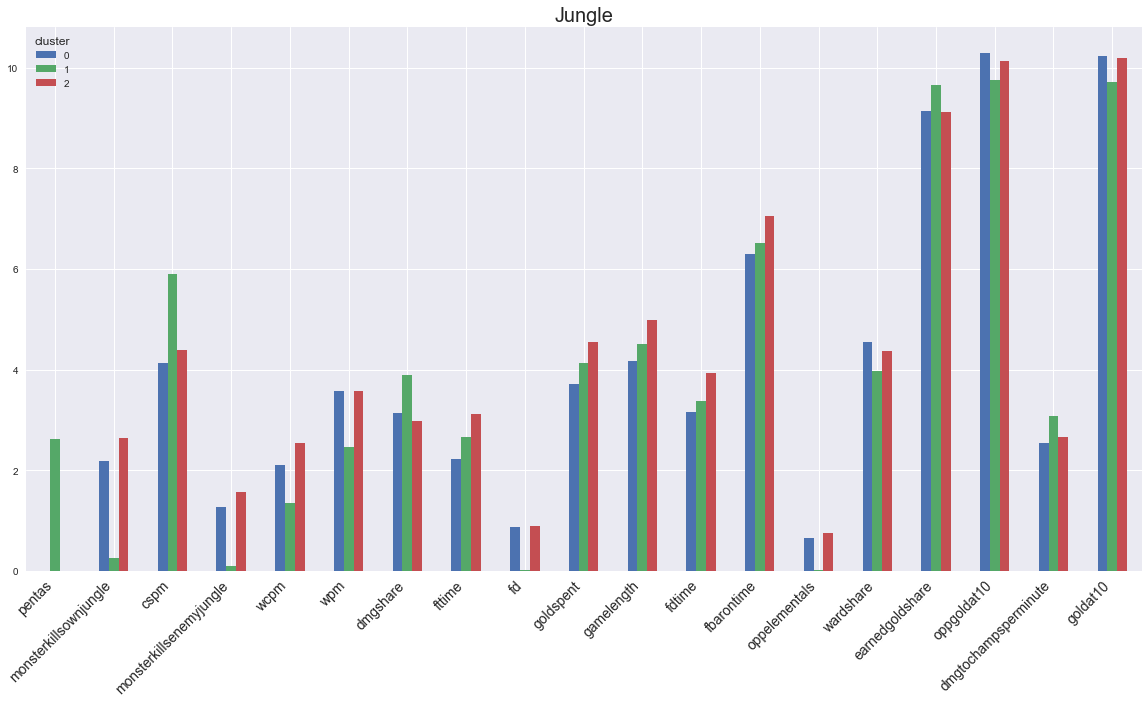

In [352]:
show_cluster_factors(full_pos_DFs['Jungle'], .5)

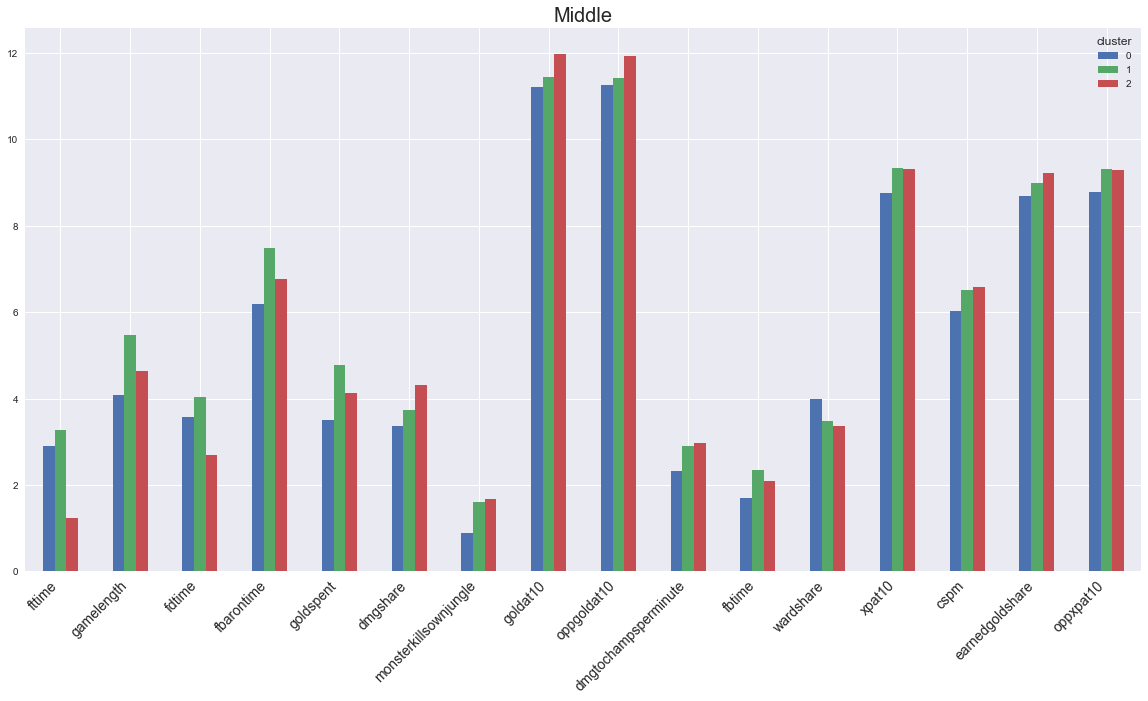

In [353]:
show_cluster_factors(full_pos_DFs['Middle'], .5)

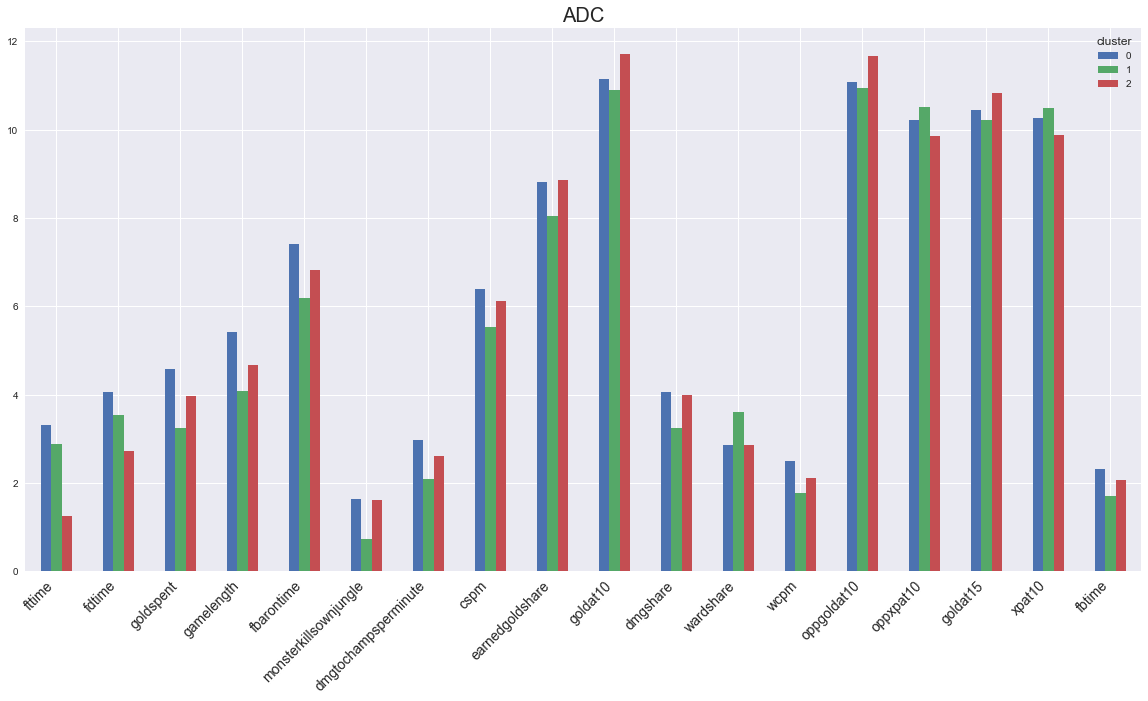

In [354]:
show_cluster_factors(full_pos_DFs['ADC'], .5)

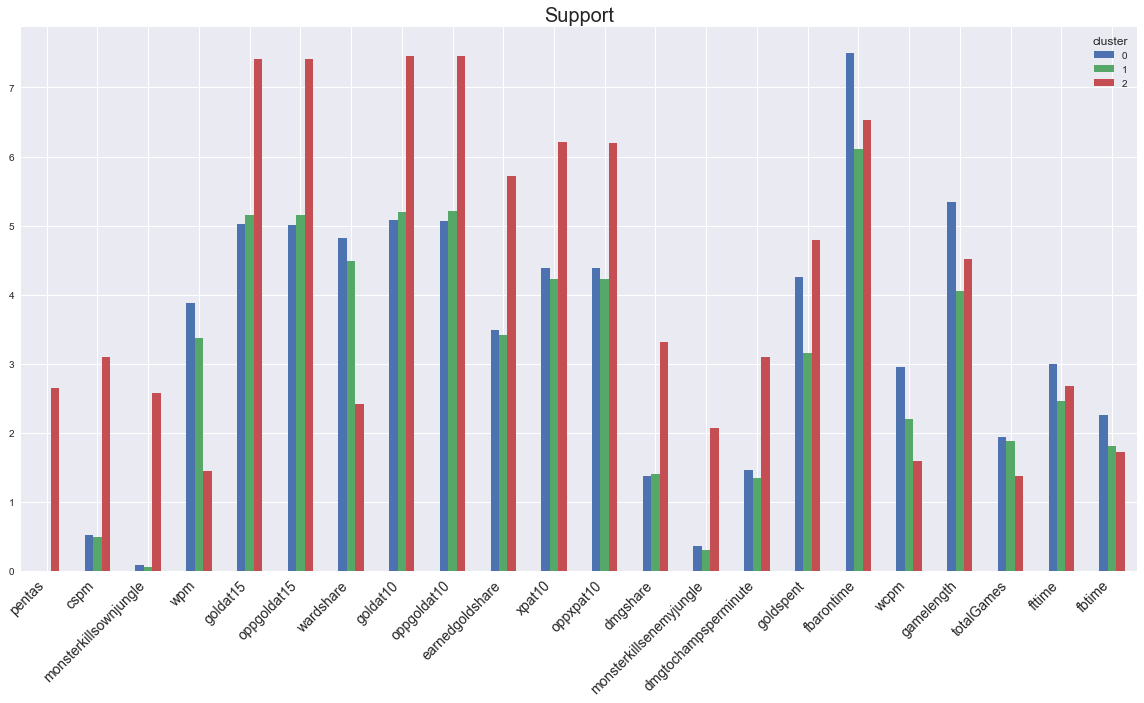

In [355]:
show_cluster_factors(full_pos_DFs['Support'], .5)

**ALEX NOTES**:

- Keep documenting findings so you don't lose them and are able to explain them to others as you go deeper.
- Try to modularize code as much as possible to prevent duplication.
- Make use of new vis suite.

In [34]:
leaks = ['teamtowerkills', 'teamkills', 'fbaron', 'gspd', 'teambaronkills', 'teamdragkills',
         'a', 'firsttothreetowers', 'kpm', 'k', 'gdat15', 'teamWinRate', 'totalgold', 'doubles',
        'goldspent', 'totalGames', 'goldat15', 'triples', 'elementals', 'fbassist', 'airdrakes',
        'firedrakes', 'earthdrakes', 'elders', 'quadras', 'pentas', 'opptowerkills', 'teamdeaths',
        'oppbaronkills', 'oppdragkills', 'd', 'okpm', 'oppgoldat15', 'oppelementals', 'fbvictim',
        'oppelders', 'oppxpat10', 'waterdrakes', 'fb']

maybe = ['earnedgmp', 'firstmidouter', 'ft', 'herald', 'gdat10', 'dmgtochampsperminute',
         'xpdat10', 'dmgtochamps', 'fd', 'goldat10', 'monsterkills', 'xpat10', 'cspm', 'minionkills',
        'oppgoldat10', 'earnedgpm']

# from previous vif testing
player_vif_inflators = ['result', 'oppxpat10', 'oppgoldat15', 'oppgoldat10', 'elementals',
                        'side_Blue', 'monsterkills', 'wards', 'dmgtochamps', 'minionkills',
                       'ckpm', 'k', 'wardkills', 'totalgold', 'earnedgpm', 'teamdragkills',
                        'visionwardbuys', 'visionwards', 'teamdeaths']

loose_regs = list(set(list(tsneDF)) - set(leaks))
tight_regs = list(set(loose_regs) - set(maybe))

loose_regs = list(set(list(loose_regs)) - set(player_vif_inflators))
tight_regs = list(set(list(tight_regs)) - set(player_vif_inflators))

regs = tight_regs
print(regs)

['fbarontime', 'side_Red', 'fb', 'wpm', 'fttime', 'fbtime', 'gamelength', 'wardshare', 'monsterkillsownjungle', 'dmgshare', 'fdtime', 'waterdrakes', 'monsterkillsenemyjungle', 'wcpm', 'earnedgoldshare']


# Work in progress

In [ ]:
# top_clust = tops[['team','cluster']].copy()
# top_clust.reset_index(inplace = True)
# top_clust.set_index(['gameid','team'], inplace = True)
# top_clust.sort_index(inplace = True)
# top_clust.drop(['player'], axis = 'columns', inplace = True)
# top_clust = pd.get_dummies(top_clust, prefix = 'TopLane_')
# norm_teamDF = norm_teamDF.join(top_clust)

### Sidenote:

I mentioned that I would like to do an evaluation with more features at some point but only using observations that are considered close games by `gspd`. This would allow me to include otherwise 'leaky' features because they won't have the same impact on the final model. IE, having a top laner with a lot of deaths in one of these games may have been a strategic decision where a team sacrifices control of one side of the map in order to find advantages on the other side.

Unfortunately, there aren't a lot of close games to use in a model. So I'm curious what your thoughts are on this. How far can I stretch p-values to still call the games close if I want to expand the range of what I call close games. Or, if I maintain a small sample size, can I cheat it bigger with bootstrapping?

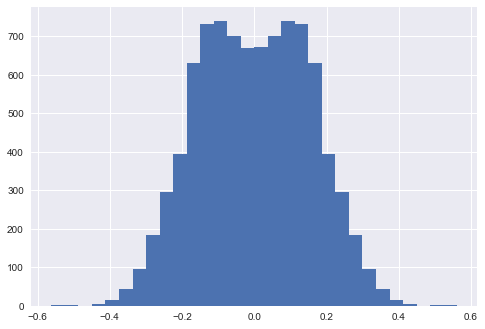

(25, 98)
0.48
Ttest_relResult(statistic=-0.19611613513818402, pvalue=0.84617037734608591)
Ttest_indResult(statistic=-0.19975041822311876, pvalue=0.84167953919130911)
Ttest_1sampResult(statistic=-0.19611613513818418, pvalue=0.8461703773460858)


In [134]:
teamDF.gspd.hist(bins = 30)
plt.show()

close_games = teamDF[(teamDF.gspd < 0) & (teamDF.gspd > -.001)]
print(close_games.shape)
print(close_games.result.mean())
print(stats.ttest_rel(close_games.result, teamDF[(teamDF.gspd > 0) & (teamDF.gspd < .001)].result))
print(stats.ttest_ind(close_games.result, teamDF.result))
print(stats.ttest_1samp(close_games.result, .5))

In [3]:
tsneDF = k_players.copy()
tsneDF.drop(['position','team','champion', 'patchno'], axis = 'columns', inplace = True)
tsneDF = pd.get_dummies(tsneDF, columns = ['side'])
m = tsneDF.max(axis = 0, numeric_only = True)
cats = list(m[m == 1].index)
nums = list(set(list(tsneDF)) - set(cats))
print('---- BEFORE SCALING ---- \n', tsneDF.iloc[:2,:8])
tsneDF.loc[:,nums] = StandardScaler().fit_transform(tsneDF.loc[:,nums])
print('\n ---- AFTER SCALING ---- \n',tsneDF.iloc[:2,:8])

---- BEFORE SCALING ---- 
                   gamelength  result  k  d   a  teamkills  teamdeaths  doubles
gameid  player                                                                
1000029 Chei       40.316667       1  1  2  15         18           8      0.0
        Flawless   40.316667       0  1  3   7          8          18      0.0

 ---- AFTER SCALING ---- 
                   gamelength  result         k         d         a  teamkills  \
gameid  player                                                                  
1000029 Chei        0.503994       1 -0.594972 -0.250135  2.227901   0.875717   
        Flawless    0.503994       0 -0.594972  0.311379  0.279601  -0.635386   

                  teamdeaths   doubles  
gameid  player                          
1000029 Chei       -0.638075 -0.392659  
        Flawless    0.871332 -0.392659  
